# Análisis de fraude

En este ejemplo vamos a analizar los datos de una empresa de transporte y analizar un posible fraude de los trabajadores en el repostaje de combustible. Concretamente vamos a examinar los informes de las tarjetas de combustible de algunos empleados de la compañía, situada en Washington DC, para lo que será imprescindible tener en cuenta el factor geoespacial y para lo que utilizaremos algunas herramientas de geoprocesamiento.

## Conexión a la organización GIS

In [1]:
from arcgis.gis import GIS
gis = GIS("home")

/opt/conda/lib/python3.9/site-packages/arcgis/gis/__init__.py:597: UserWarning: You are logged on as liber.preventas with an administrator role, proceed with caution.
  warnings.warn(


## Carga de datos

Los datos de transacciones los tenemos en formato CSV y en él encontramos información como nombre de la gasolinera, tipo de combustible y precio de la transacción. 

In [2]:
import pandas as pd

In [3]:
# Ruta del archivo CSV
csv_file = 'https://downloads.esri.com/learnarcgis/analyze-credit-card-fraud/gastransactions.csv'

# Leemos el archivo CSV utilizando pandas
data_frame = pd.read_csv(csv_file)

# Mostramos los primeros 5 registros del archivo CSV
data_frame.head()

,BUSINESS_NAME,ADDR,CITY,STATE,ZIP,ZIP4,PAY,FUEL_TYPE,CARD_OWNER,CARD_NAME,CARD_OWNER_HOME
0,Antique gas,13495 Minnieville Rd,Woodbridge,VA,22192,4214.0,86.33,Diesel,1,BUFORD,"Washington, DC"
1,Antique gas,6800 Baltimore Ave,Lansdowne,PA,19050,2737.0,85.22,Diesel,1,BUFORD,"Washington, DC"
2,Soprano Mart,1545 Route 22 E ste 1,Annandale,NJ,8801,3096.0,90.22,Diesel,2,MADER,"Rockville, MD"
3,Coffee & Fuel,5211 Ox Rd,Fairfax,VA,22030,4517.0,89.55,Diesel,2,MADER,"Rockville, MD"
4,Soprano Mart,200 Rte 17 Ste 215,Mahwah,NJ,7430,1243.0,84.54,Diesel,2,MADER,"Rockville, MD"


In [4]:
data_frame.shape
# Resumen de datos: 94 registros, 11 columnas por fila

(94, 11)

### Publicamos los datos como capa en nuestra organización

In [5]:
gas_station_csv = {'title': 'Gas Station - Fraud',  'description': 'Gas station transaction data from USA. Data for demo' }
gas_station_item = gis.content.add(item_properties= gas_station_csv, data= csv_file)
gas_station_item

<Item title:"Gas Station - Fraud" type:CSV owner:liber.preventas>

In [7]:
gas_station_fl = gas_station_item.publish()
gas_station_fl

<Item title:"Gas Station - Fraud" type:Feature Layer Collection owner:liber.preventas>

In [8]:
# Cargamos los datos como capa para previsualizarlos
map = gis.map('Philadelphia', zoomlevel= 6)
map.add_layer(gas_station_fl, {
    "renderer": "simple",
    "symbol": {
        "type": "styleSymbolReference",
        "styleName": "Esri2DPointSymbolsStyle",
        "name": "gas-station"
    }
})

In [9]:
map.basemaps

['dark-gray',
 'dark-gray-vector',
 'gray',
 'gray-vector',
 'hybrid',
 'national-geographic',
 'oceans',
 'osm',
 'satellite',
 'streets',
 'streets-navigation-vector',
 'streets-night-vector',
 'streets-relief-vector',
 'streets-vector',
 'terrain',
 'topo',
 'topo-vector']

In [10]:
map.basemap = 'streets-navigation-vector'
map

MapView(layout=Layout(height='400px', width='100%'))

## Calcular ruta autorizada

### Geocodificación del inicio y final de la ruta

![geocode](https://developers.arcgis.com/assets/img/features/features-hero_geocoding.png)

In [11]:
from arcgis.geocoding import geocode

In [12]:
start = '900 Brentwood Road NE, Washington, District of Columbia, USA'
end = '250 N Boundary Road, Jamaica, New York, USA'

In [13]:
coord_start = geocode(start)
coord_start

[{'address': '900 Brentwood Rd NE, Washington, District of Columbia, 20018',
  'location': {'x': -76.99548883223696, 'y': 38.917324090803646},
  'score': 100,
  'attributes': {'Loc_name': 'World',
   'Status': 'M',
   'Score': 100,
   'Match_addr': '900 Brentwood Rd NE, Washington, District of Columbia, 20018',
   'LongLabel': '900 Brentwood Rd NE, Washington, DC, 20018, USA',
   'ShortLabel': '900 Brentwood Rd NE',
   'Addr_type': 'PointAddress',
   'Type': '',
   'PlaceName': '',
   'Place_addr': '900 Brentwood Rd NE, Washington, District of Columbia, 20018',
   'Phone': '',
   'URL': '',
   'Rank': 20,
   'AddBldg': '',
   'AddNum': '900',
   'AddNumFrom': '',
   'AddNumTo': '',
   'AddRange': '',
   'Side': '',
   'StPreDir': '',
   'StPreType': '',
   'StName': 'Brentwood',
   'StType': 'Rd',
   'StDir': 'NE',
   'BldgType': '',
   'BldgName': '',
   'LevelType': '',
   'LevelName': '',
   'UnitType': '',
   'UnitName': '',
   'SubAddr': '',
   'StAddr': '900 Brentwood Rd NE',
   

In [14]:
startX = str(coord_start[0]['location']['x'])
startY = str(coord_start[0]['location']['y'])

In [15]:
from arcgis.geometry import Point

In [16]:
ptStart = Point({
    'x': coord_start[0]['location']['x'],
    'y': coord_start[0]['location']['y'],
    'spatialReference': {'wkid': 4326}
})

In [17]:
symbol_start = {
  "type": "styleSymbolReference",
  "styleName": "Esri2DPointSymbolsStyle",
  "name": "tear-pin-2"
}

In [18]:
map.draw(ptStart, symbol=symbol_start)

In [19]:
coord_end = geocode(end)
endX = str(coord_end[0]['location']['x'])
endY = str(coord_end[0]['location']['y'])

In [20]:
ptEnd = Point({
    'x': coord_end[0]['location']['x'],
    'y': coord_end[0]['location']['y'],
    'spatialReference': {'wkid': 4326}
})

In [21]:
symbol_end = {
  "type": "styleSymbolReference",
  "styleName": "Esri2DPointSymbolsStyle",
  "name": "tear-pin-1"
}

In [22]:
map.draw(ptEnd, symbol=symbol_end)

### Creación de la ruta

![rutas](https://www.esri.es/content/dam/esrisites/en-us/arcgis/location-services/arcgis-platfrom-update/assets/routing-directions/routing-directions-small-banner.png)

#### Obtenemos token de ArcGIS Online

In [23]:
import requests
import json

In [24]:
import getpass

In [39]:
urlToken = "https://www.arcgis.com/sharing/rest/generateToken"
# 'username': 
payload = {
    'f': 'json',
    'username': getpass.getpass('Introduce tu usuario de ArcGIS Online: '),
    'password':getpass.getpass("Introduce contraseña: "),
    'client':'referer',
    'referer':'https://www.arcgis.com',
    'expiration':120
}
headers = {
  'Content-Type': 'application/x-www-form-urlencoded'
}

response = requests.request("POST", urlToken, headers=headers, data=payload)

resp = json.loads(response.text)
token = resp['token']
print(token)

Introduce tu usuario de ArcGIS Online: ········
Introduce contraseña: ········
RXLLRgUhhzUU9ZObpNz8Lyh9I9-gj2OzLOBsmCBiJctTW9pqLnmJr0kF6Jw84L8cCQrRLpTyTODonkw-zrlkGRxXfta3wmX_9n6O_XEJzvELsm5BsgKnSZfJpfAyVs814i8erYD5mOanoJFessXAqNBanwU1hWPdgObRiAFR3Y3t8WHenO9MiKLy17e2Ebdh


#### Ruta

![Opciones de desarrollo](https://preventas.maps.arcgis.com/sharing/rest/content/items/81c2c34262fc47b3b06b90f1f40219c7/data)

In [40]:
# Petición a la API REST para obtener ruta
url = "https://route.arcgis.com/arcgis/rest/services/World/Route/NAServer/Route_World/solve?f=json&token="+token+"&stops="+startX+','+startY+';'+endX+','+endY+"&startTime=now&returnDirections=true&directionsLanguage=es&outSR=102100"

payload = {}
headers = {
  'Cookie': 'AGS_ROLES=ucVQDcI1D/MzhZtfPKU1nKZ+tdcDPxgB/iYsD85qMFvCYuwqPgJp9RNR7rp/3OC7HauPNE1YoKK1yeLTDPF6vw7k3ALVU+tv+7cdz4n0oeT5bYQWohXu/GHOtWhF4jfMZwLq79TmmCGIx9jRlk4oVtbwSTMC8kFiCmMenZ+B2zy7XjqLdlDhRA2DMEeiEb0ZkFR/984sHSEwicsiM6cLLs/l693N8otnoEOTa+V8VseBeFLW5Epm3i6jCf7fPVRL647k8hGZguZpotKYRB2SnNtmv1bq3mUn1U9G9P1EErumJwTn8tsopzGGTP/OlgOBcI2wx03v4HMyO2hsdgtnuJ+/F/wLsjDLxXKY7SZenALrSyXl2Vs0c20r50t8+jIuVbNdKsgkQg0jitKIeR//nGysZpgcPtaHXY9+cwAyqnOLHhhCoREhLJsxZH0ozUuN9pCUJx1HosjjlXhWxB4buu99U3v4flErONkU+9T7jIlh3HlSM7VZcUxe+VsjCHNEytcVpjpyMcA+84r4r5kpqSKOVQ8mF0HA6KhksF+gkaCTNeaVqJtUPStnavnwMgiId3vUkW7helLktDwvpo5E8Xb979jSfDIxv+uLpfy1CTOHxqPgRUzlIieTLAD1ei6IXWhuTkXUWWZQodzWuhR9A04lLni7STNk9nCHMBoaWhVXXoRtwc6nsUfOXmbvkuo1kXz/2qLXnNQ3ndgOXrkAL1I49Uua1oJvwYZFA+i9vJKRis98ns/gavVjnRLcVzW6IfbshfDaB13/WXufhuv1O6zYjJNOYkoTMQGfa5K2stK6Fv2U4FXV6m+lZ9pzfRjvj0iEtCFxUZcyZCu9trZLqqeSlzp5PsDFgCoc1lFuGDghupqj3TVSuzxqyXL29PDI+W9PTBY3m814fgflfes+qHYxXUo9nPxCYLsXD4SzTjMEJadv5If5ZvckEF6X/jBobkS+xOBbE2lUUXHA/zNKK4AOtsUzp0bSB0ZM12YCalhiHapws0A8D+bI/R8hkM1/MlEJy5q7Y3t0glCS/xi0Shg7N+i4wIDppWmKNfe6hv6LMeTvzBVKAluPb7Lr3tWHD7Se8kHOIpudytZVSfoK5djOqHg4LSH2DwOwGGR6CJNXbCRW3iPn4FPn2cQykQYP'
}

response = requests.request("GET", url, headers=headers, data=payload)

route = json.loads(response.text)

In [42]:
route

{'checksum': 'kI5HAjObZwI.',
 'requestID': '2909d4a7-4872-4712-8609-40317d38d6b9',
 'routes': {'fieldAliases': {'ObjectID': 'ObjectID',
   'Name': 'Name',
   'FirstStopID': 'FirstStopID',
   'LastStopID': 'LastStopID',
   'StopCount': 'StopCount',
   'StartTime': 'StartTime',
   'EndTime': 'EndTime',
   'StartTimeUTC': 'StartTimeUTC',
   'EndTimeUTC': 'EndTimeUTC',
   'Total_TravelTime': 'Total_TravelTime',
   'Total_Miles': 'Total_Miles',
   'Total_Kilometers': 'Total_Kilometers',
   'Shape_Length': 'Shape_Length'},
  'geometryType': 'esriGeometryPolyline',
  'spatialReference': {'wkid': 102100, 'latestWkid': 3857},
  'fields': [{'name': 'ObjectID',
    'type': 'esriFieldTypeOID',
    'alias': 'ObjectID'},
   {'name': 'Name',
    'type': 'esriFieldTypeString',
    'alias': 'Name',
    'length': 1024},
   {'name': 'FirstStopID',
    'type': 'esriFieldTypeInteger',
    'alias': 'FirstStopID'},
   {'name': 'LastStopID',
    'type': 'esriFieldTypeInteger',
    'alias': 'LastStopID'},
   {

In [43]:
from arcgis.geometry import Polyline

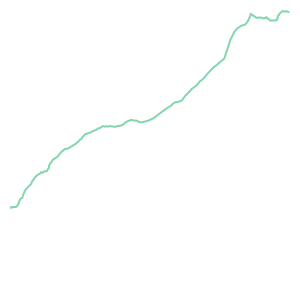

In [44]:
# Construimos ruta como una polilínea
geometry = route['routes']['features'][0]['geometry']['paths']
sR = route['routes']['spatialReference']

line = {
    'paths': geometry,
    'spatialReference': sR
}
polyline = Polyline(line)
polyline

In [45]:
symbol_line = {
  "type": "esriSLS",
  "color": [
    14,
    145,
    221,
    255
  ],
  "width": 3,
  "style": "esriSLSSolid",
  "cap": "butt"
}

In [46]:
map.draw(polyline, symbol=symbol_line)

## Buffer de 15 km

In [47]:
from arcgis.geometry.functions import buffer

In [48]:
route_buffer = buffer(geometries=[polyline],
                      in_sr=3857,
                      distances=15000,
                      unit="9001",
                      out_sr=None, 
                      buffer_sr=None, 
                      union_results=None,
                      geodesic=None, 
                      gis=gis)
route_buffer

[{'rings': [[[-8235075.291200001, 4935964.445],
    [-8235774.909013691, 4935980.769385694],
    [-8235931.869513691, 4935988.098185694],
    [-8236213.298638453, 4936003.889951422],
    [-8237190.144583302, 4936100.1008793935],
    [-8238029.659203547, 4936234.931829649],
    [-8238516.125403547, 4936327.274829651],
    [-8238645.072730242, 4936352.337593954],
    [-8239340.717285234, 4936507.97993429],
    [-8239482.093085232, 4936543.158434287],
    [-8239742.379376537, 4936610.407905663],
    [-8240141.716813301, 4936723.35346944],
    [-8240422.241913301, 4936806.902969443],
    [-8240962.210779547, 4936978.892857577],
    [-8241152.595029707, 4937044.949119498],
    [-8241210.481129707, 4937065.470119496],
    [-8241615.611276874, 4937215.694138798],
    [-8241653.459876874, 4937230.352038796],
    [-8241976.604985476, 4937359.83071233],
    [-8242870.683853284, 4937764.932577008],
    [-8243656.728647408, 4938181.995444747],
    [-8243870.462147408, 4938303.656944746],
    [-824

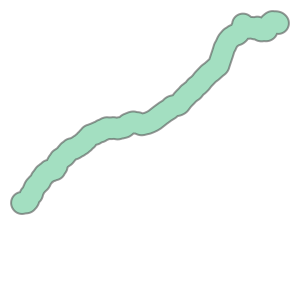

In [49]:
buffered_route = route_buffer[0]
buffered_route

In [50]:
style_buffer = {
  "type": "esriSFS",
  "color": [
    32,
    182,
    172,
    255
  ],
  "outline": {
    "type": "esriSLS",
    "color": [
      32,
      182,
      172,
      255
    ],
    "width": 3,
    "style": "esriSLSSolid"
  },
   "style": "esriSFSDiagonalCross"
}

In [51]:
map1 = gis.map('Philadelphia')
map1

MapView(layout=Layout(height='400px', width='100%'))

In [53]:
map.draw(buffered_route, symbol=style_buffer)

## Eliminar elementos fuera del buffer

In [54]:
from arcgis.features import FeatureLayer

In [55]:
from arcgis.geometry.filters import contains

In [56]:
gas_station_fl

<Item title:"Gas Station - Fraud" type:Feature Layer Collection owner:liber.preventas>

In [57]:
# Accedemos al servicio
stops_fl = FeatureLayer(gas_station_fl.url+'/0')
stops_fl

<FeatureLayer url:"https://services1.arcgis.com/YFraetVkEAF1lMag/arcgis/rest/services/Gas_Station_Fraud/FeatureServer/0">

In [58]:
# Total de datos
stops_fl.query(where='1=1')

<FeatureSet> 94 features

In [59]:
inside_buffer = contains(buffered_route)
features_inside = stops_fl.query(geometry_filter=inside_buffer)
features_inside

<FeatureSet> 24 features

In [60]:
# Borrar elementos con el filtro geométrico
stops_fl.delete_features(geometry_filter=inside_buffer)

{'deleteResults': [{'objectId': 11,
   'uniqueId': 11,
   'globalId': None,
   'success': True},
  {'objectId': 19, 'uniqueId': 19, 'globalId': None, 'success': True},
  {'objectId': 21, 'uniqueId': 21, 'globalId': None, 'success': True},
  {'objectId': 23, 'uniqueId': 23, 'globalId': None, 'success': True},
  {'objectId': 25, 'uniqueId': 25, 'globalId': None, 'success': True},
  {'objectId': 29, 'uniqueId': 29, 'globalId': None, 'success': True},
  {'objectId': 33, 'uniqueId': 33, 'globalId': None, 'success': True},
  {'objectId': 34, 'uniqueId': 34, 'globalId': None, 'success': True},
  {'objectId': 35, 'uniqueId': 35, 'globalId': None, 'success': True},
  {'objectId': 36, 'uniqueId': 36, 'globalId': None, 'success': True},
  {'objectId': 38, 'uniqueId': 38, 'globalId': None, 'success': True},
  {'objectId': 48, 'uniqueId': 48, 'globalId': None, 'success': True},
  {'objectId': 50, 'uniqueId': 50, 'globalId': None, 'success': True},
  {'objectId': 52, 'uniqueId': 52, 'globalId': None

In [61]:
# Datos fuera del buffer
stops_fl.query(where='1=1')

<FeatureSet> 70 features

In [62]:
map1 = gis.map('Philadelphia')
map1.add_layer(stops_fl)

In [63]:
map1

MapView(layout=Layout(height='400px', width='100%'))

In [64]:
def drawGraphics(map):
    # Buffer de la ruta
    map.draw(buffered_route, symbol=style_buffer)
    
    #Ruta
    map.draw(polyline, symbol=symbol_line)
    
    # Punto de inicio y de fin
    map.draw(ptStart, symbol=symbol_start)
    map.draw(ptEnd, symbol=symbol_end)

In [ ]:
map2.draw(buffered_route, symbol=style_buffer)

### Filtrar datos anómalos

In [68]:
stops_fl.query().sdf

,BUSINESS_NAME,ADDR,CITY,STATE,ZIP,ZIP4,PAY,FUEL_TYPE,CARD_OWNER,CARD_NAME,CARD_OWNER_HOME,ObjectId,SHAPE
0,Antique gas,13495 Minnieville Rd,Woodbridge,VA,22192,4214.0,86.33,Diesel,1,BUFORD,"Washington, DC",1,"{""x"": -8601932.0461, ""y"": 4675263.5101, ""spati..."
1,Antique gas,6800 Baltimore Ave,Lansdowne,PA,19050,2737.0,85.22,Diesel,1,BUFORD,"Washington, DC",2,"{""x"": -8379134.9575, ""y"": 4857733.069200002, ""..."
2,Soprano Mart,1545 Route 22 E ste 1,Annandale,NJ,8801,3096.0,90.22,Diesel,2,MADER,"Rockville, MD",3,"{""x"": -8337358.4669, ""y"": 4954796.234499998, ""..."
3,Coffee & Fuel,5211 Ox Rd,Fairfax,VA,22030,4517.0,89.55,Diesel,2,MADER,"Rockville, MD",4,"{""x"": -8609673.3705, ""y"": 4700607.8292, ""spati..."
4,Soprano Mart,200 Rte 17 Ste 215,Mahwah,NJ,7430,1243.0,84.54,Diesel,2,MADER,"Rockville, MD",5,"{""x"": -8254471.0427, ""y"": 5026797.064999998, ""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Vintage Gas & Go,92 Feneral Rd,Danbury,CT,6810,5034.0,31.12,Gas,1,BUFORD,"Washington, DC",87,"{""x"": -8177090.081700001, ""y"": 5071197.5540999..."
66,Vintage Gas & Go,Church St & Valley Rd,Liberty Corner,NJ,7938,NaN,127.78,Diesel,3,BO,"Arlington, VA",91,"{""x"": -8301964.946900001, ""y"": 4962358.5077999..."
67,Vintage Gas & Go,14000 Lee Jackson Hwy,Chantilly,VA,20151,1602.0,120.33,Diesel,3,BO,"Arlington, VA",92,"{""x"": -8619525.4905, ""y"": 4706177.572099999, ""..."
68,Swabbie Fuels,313 Buschs Frontage Rd,Annapolis,MD,21409,5534.0,100.23,Diesel,1,BUFORD,"Washington, DC",93,"{""x"": -8509677.0979, ""y"": 4728033.488600001, ""..."


No todos los puntos que están fuera del buffer son sospechosos, solo serán aquellos que el importe del repostaje sea mayor de 120$ o que el repostaje sea de gasolina

In [69]:
suspicious = stops_fl.query(where="FUEL_TYPE = 'Gas' OR PAY >= 120")
suspicious

<FeatureSet> 7 features

In [71]:
# Añadimos al mapa para ver los puntos
map1.add_layer(suspicious, {
    "renderer": "simple",
    "symbol": {
      "type": "esriSMS",
      "color": [194,0,142,255],
    "style": "esriSMSCircle"
    }
})

In [72]:
map1

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), ready=True)

In [73]:
stops_fl.query(where="FUEL_TYPE = 'Gas' OR PAY >= 125").sdf

,BUSINESS_NAME,ADDR,CITY,STATE,ZIP,ZIP4,PAY,FUEL_TYPE,CARD_OWNER,CARD_NAME,CARD_OWNER_HOME,ObjectId,SHAPE
0,Vintage Gas & Go,1820 Hooper Ave,Toms River,NJ,8753,8163.0,145.55,Diesel,1,BUFORD,"Washington, DC",83,"{""x"": -8259238.8565, ""y"": 4859781.286399998, ""..."
1,Vintage Gas & Go,8156 Richmond Hwy Ste 58,Alexandria,VA,22309,3725.0,139.98,Diesel,1,BUFORD,"Washington, DC",84,"{""x"": -8582393.7723, ""y"": 4683777.661200002, ""..."
2,Vintage Gas & Go,10811 Reisterstown Rd B,Owings Mills,MD,21117,2812.0,125.02,Diesel,1,BUFORD,"Washington, DC",85,"{""x"": -8547250.2091, ""y"": 4781750.521499999, ""..."
3,Vintage Gas & Go,700 Route 72 E,Manahawkin,NJ,8050,3815.0,34.85,Gas,1,BUFORD,"Washington, DC",86,"{""x"": -8264300.5538, ""y"": 4819737.170699999, ""..."
4,Vintage Gas & Go,92 Feneral Rd,Danbury,CT,6810,5034.0,31.12,Gas,1,BUFORD,"Washington, DC",87,"{""x"": -8177090.081700001, ""y"": 5071197.5540999..."
5,Vintage Gas & Go,Church St & Valley Rd,Liberty Corner,NJ,7938,NaN,127.78,Diesel,3,BO,"Arlington, VA",91,"{""x"": -8301964.946900001, ""y"": 4962358.5077999..."


## Conclusión
Nuestro punto de partida eran más de 90 transacciones, pero gracias al análisis espacial hemos podido identificar las transacciones sospechosas de haber provocado fraude,ya que hemos podido evaluar la ruta más rápida entre los puntos de inicio y fin preestablecidos y ver cuáles eran las transacciones que se encontraban fuera de lo esperado tanto por el tipo de compra como por el importe. 